First lets open our file
Each name is written in next line, so splitlines breaks eaach line apart and returns a list.

In [ ]:
with open('names.txt','r') as r:
    words = r.read()
    words = words.splitlines()


lets see the first 5 words

In [ ]:
words[:5]

Each of our trigram must look like this:
1. For every word in words. Eg - Harsh
2. The trigram looks like 
    1. .S. H A
    2. A R S
    3. S H .S.
2. We add to a dict B, the trigram wherein:
    1. Key = Trigram
    2. Value = Count

In [ ]:
b = {}
for n in words:
    chs = ['<S>'] + list(n) + ['<E>']
    for ch1,ch2,ch3 in zip(chs,chs[1:],chs[2:]):
        trigram = (ch1,ch2,ch3)
        b[trigram] = b.get(trigram,0) + 1

In [370]:
item = list(b.items())
item[:1]

[(('<S>', 'e', 'm'), 288)]

Next we sort the dict of trigrams
1. The dict.items returns a list of tuples --> each tuple is (trigram,count)
2. We pass in the key, so that it sorts by the counts, wherein for each tuple it returns the counts 
3. Reverse = True, sorts in descending order.

In [360]:
sorted(b.items(),key= lambda kv: kv[1],reverse=True)

[(('a', 'h', '<E>'), 1714),
 (('n', 'a', '<E>'), 1673),
 (('a', 'n', '<E>'), 1509),
 (('o', 'n', '<E>'), 1503),
 (('<S>', 'm', 'a'), 1453),
 (('<S>', 'j', 'a'), 1255),
 (('<S>', 'k', 'a'), 1254),
 (('e', 'n', '<E>'), 1217),
 (('l', 'y', 'n'), 976),
 (('y', 'n', '<E>'), 953),
 (('a', 'r', 'i'), 950),
 (('i', 'a', '<E>'), 903),
 (('i', 'e', '<E>'), 858),
 (('a', 'n', 'n'), 825),
 (('e', 'l', 'l'), 822),
 (('a', 'n', 'a'), 804),
 (('i', 'a', 'n'), 790),
 (('m', 'a', 'r'), 776),
 (('i', 'n', '<E>'), 766),
 (('e', 'l', '<E>'), 727),
 (('y', 'a', '<E>'), 716),
 (('a', 'n', 'i'), 703),
 (('<S>', 'd', 'a'), 700),
 (('l', 'a', '<E>'), 684),
 (('e', 'r', '<E>'), 683),
 (('i', 'y', 'a'), 669),
 (('l', 'a', 'n'), 647),
 (('<S>', 'b', 'r'), 646),
 (('n', 'n', 'a'), 633),
 (('<S>', 'a', 'l'), 632),
 (('<S>', 'c', 'a'), 628),
 (('r', 'a', '<E>'), 627),
 (('n', 'i', '<E>'), 625),
 (('<S>', 'a', 'n'), 623),
 (('n', 'n', '<E>'), 619),
 (('n', 'e', '<E>'), 607),
 (('e', 'e', '<E>'), 605),
 (('e', 'y', '<

Then we create a lookup, to get Alphabet and their index.

In [ ]:
chars  = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
stoi

Also we create a reverse lookup, to get index and its alphabet.

In [ ]:
itos = {s:i for i,s in stoi.items()}
itos

In [ ]:
count = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2,ch3 in zip(chs,chs[1:],chs[2:]):
        # ix1 = stoi[ch1]
        # ix2 = stoi[ch2]
        # ix3 = stoi[ch3]
        # print(ix1,ix2,ix3)
        # print(ch1,ch2,ch3)
        count+=1
print(count)

Now we created a list of features xs, and targets ys 

In [ ]:
import torch

xs,ys = [],[]

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2,ch3 in zip(chs,chs[1:],chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1,ix2])
        ys.append(ix3)

# we convert xs and ys into tensors for efficient matrix operations
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# next we encode each of xs and ys as one-hot encoded tensors
import torch.nn.functional as F
xenc = F.one_hot(xs,num_classes=27).float()
yenc = F.one_hot(ys,num_classes=27).float()

# we're introduced to the tensor.view(-1) for the first time here
# the -1 simply is a magic paramter that automatically calculated one dimemsnion of our output tensor. 
# so in this case, we can have an output tensor that will automatically calculate rows, but will have fixed 2*27 columns for each
# of the beginning 2 chars (one hot encoded --> 27 possibitilies for each = 2*27 = 54) that we use to predict the third.

xflat = xenc.view(-1,2*27) #we construct this to be able to multiply it with the weight tensor

In [ ]:
g = torch.Generator().manual_seed(5)
w = torch.randn((27*2,27),generator=g,requires_grad=True)
w

## Lets explore the training loop.
1. Forward pass (Why multiply it with a weight?? So that weights are able to express what they think of the inputs)
2. We do exponentiation as we don't want to play with -ve values. Now the next question is why do we don't just square --> x^2 changes it ordering, but e^x does not as large -ve values stay btw 0 and 1. 
    
    Here's the graph of e^x

    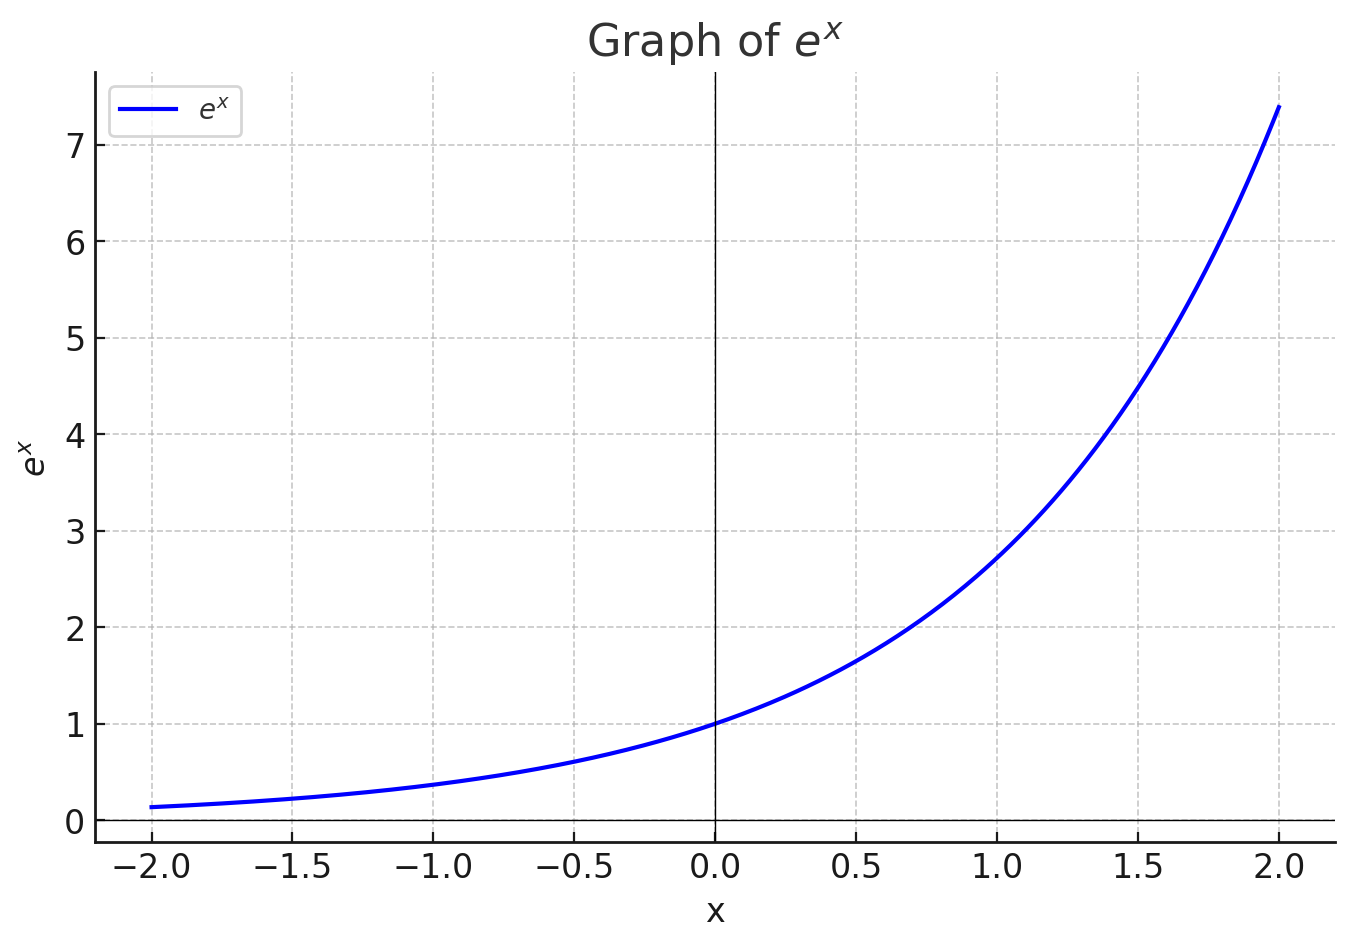

3. Now we find out probability for each class in our output, which all sum to one.
    1. The 1, keepdim are passed in to ensure we get the probabilities across rows and not columns, and in correct dimensions.

4. Our loss function is the average negative log likelihood
    1. probs[torch.arange(len(ys)),ys] fetches from each row of probs --> torch.arange(len(ys)) , the probability that weights think for a true label ys
    2. Think of this as a super efficient way to fetch what is the probability that our model thinks is of true label --> ys
    3. We log it as:
        1. Probabilities are between 0 and 1. 
        2. Log probabilities are between -∞ and 0 (because log(x) for 0<x<1 is negative).
        3. Negating makes them positive, and bigger values mean worse performance (since we’re taking log of probabilities assigned to correct classes).
        4. So if a prediction is confident and correct, log(prob) is closer to 0. If a prediction is wrong or uncertain, log(prob) is very negative → negation makes it a large positive loss.
5. We reset our grads after each iteration so that they don't accumulate and do a .backward() to compute them each iteration
6. Slightly nudge our weights in the direction of reducing the loss with a learning rate/step size of 50.

In [ ]:
from tqdm import trange
for n in trange(500,desc='Running gradient descent with 100 steps',colour='green'):
    # time to do grad descent 20 times
    # forward pass

    #  Why multiply it with a weight?? So that weights are able to express what they think of the inputs
    logits = (xflat @ w)

    counts = logits.exp() 

    probs = counts/counts.sum(1,keepdim=True)

    # loss
    loss = -probs[torch.arange(len(ys)),ys].log().mean()

    # backward pass
    w.grad = None
    loss.backward()

    # grad descent and updating w
    w.data += -(50 * w.grad)

    n+=1

print(f'Negative_Log_Likelihood_loss after {n} runs is: {loss:.4f}')

In [376]:
probs[torch.arange(len(ys)),ys].shape

torch.Size([196113])

## Noew , lets sample/generate from out model
1. set both starting indice to 0, as we want a rolling window of indices, wherein we pass 2, model generates the next and we keep rolling.
2. The one hot encoding and flattening is pretty standard

In [386]:
g = torch.Generator().manual_seed(42)

for _ in range(10):
    ix1, ix2 = 0, 0          # start-of-word token twice
    out = []

    while True:
        # 1) one-hot encode current 2-char context
        xs   = torch.tensor([[ix1, ix2]])              # shape [1,2]
        xenc = F.one_hot(xs, num_classes=27).float()   # [1,2,27]
        xflat = xenc.view(-1,27*2)                       # [1,54]

        # 2) project to logits
        logits = xflat @ w                             # [1,27]

        # 3) softmax → probabilities
        counts = torch.exp(logits)
        p = counts / counts.sum(dim = 1, keepdim = True)        # [27]

        # 4) sample next index
        ix1 = ix2
        ix2 = torch.multinomial(p, 1, replacement=True,generator=g).item()
        if ix2 == 0:            # 0 == end-of-word
            break
        out.append(itos[ix2])

    print(''.join(out))


anugurovi
smarbian
hante
us
ullayley
ormah
la
le
ua
achaden


In [ ]:
x = torch.zeros(2,2,27)
x.shape

In [ ]:
y = x.view(2,-1)
y

In [ ]:
y.shape